In [33]:
%config Completer.use_jedi = False

In [34]:
from pyspark.sql import SparkSession

In [35]:
from pyspark.ml.feature import CountVectorizerModel
from pyspark.ml.clustering import LocalLDAModel

In [36]:
import pyspark.sql.functions as F
from pyspark.sql.types import ArrayType, StringType, FloatType, IntegerType
from functools import reduce
from operator import add

In [37]:
import numpy as np
import pandas as pd

In [38]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
spark = SparkSession.builder \
    .config("spark.executor.memory", "128G") \
    .config("spark.driver.memory", "128G") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.kryoserializer.buffer.max", "512m") \
    .config("spark.local.dir", "/htrc/temp") \
    .master("local[*]") \
    .getOrCreate()

In [40]:
topic_model = LocalLDAModel.load('topicmodel')
topic_model

LocalLDAModel: uid=LDA_5fcbf393faae, k=20, numFeatures=262144

In [41]:
topic_model.getK()

20

In [42]:
vocab_model = CountVectorizerModel.load('vocab')
vocab_model

CountVectorizerModel: uid=CountVectorizer_5c4241403ad4, vocabularySize=262144

In [43]:
vocab = vocab_model.vocabulary

In [44]:
topics = topic_model.describeTopics(maxTermsPerTopic=20)
topics

DataFrame[topic: int, termIndices: array<int>, termWeights: array<double>]

In [45]:
index_map_udf = F.udf(lambda arr: [vocab[i] for i in arr], ArrayType(StringType()))

In [46]:
topics_with_terms = topics.withColumn('topic_terms', index_map_udf(topics.termIndices)).drop('termIndices', 'termWeights').withColumn('topic_terms', F.concat_ws(', ', F.col('topic_terms')))
topics_with_terms

DataFrame[topic: int, topic_terms: string]

In [47]:
topics_with_terms.show(truncate=False)

+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|topic_terms                                                                                                                                                                                            |
+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |united__states, cfr, national, housing, defense, designate, service, con, transportation, alien, corporation, loan, labor, commerce, appropriation, military, federal__fund, relative, education, bank |
|1    |alaska, river, map, washington, california, united__states, university, oil, issn, lake, ice, basin, russi, new__york, island, sea, county, geology, usa, florida

In [48]:
hathifiles = spark.read.csv('/htrc/shared/hathifiles/hathi_full_20210301.txt', sep='\t', header=True) \
    .select(F.col('htid'), F.col('title'), F.col('author'), F.col('rights_date_used').cast(IntegerType()), F.col('access'), F.col('rights'))
hathifiles

DataFrame[htid: string, title: string, author: string, rights_date_used: int, access: string, rights: string]

In [49]:
to_array_udf = F.udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))

In [50]:
result = spark.read.parquet('result') \
    .withColumnRenamed('_c1', 'htid') \
    .withColumnRenamed('_c2', 'seq') \
    .drop('tokens') \
    .join(hathifiles, 'htid', 'left') \
    .select(F.col('htid'), F.col('seq'), F.col('rights_date_used').alias('year'), F.posexplode(to_array_udf(F.col('topicDistribution')))) \
    .withColumnRenamed('pos', 'topic') \
    .withColumnRenamed('col', 'weight')
result.show()

+------------+--------+----+-----+------------+
|        htid|     seq|year|topic|      weight|
+------------+--------+----+-----+------------+
|chi.14822710|00000197|1973|    0|1.7056777E-4|
|chi.14822710|00000197|1973|    1|1.6877278E-4|
|chi.14822710|00000197|1973|    2| 1.708225E-4|
|chi.14822710|00000197|1973|    3|1.6617494E-4|
|chi.14822710|00000197|1973|    4|1.6398176E-4|
|chi.14822710|00000197|1973|    5|1.7354217E-4|
|chi.14822710|00000197|1973|    6|1.7507031E-4|
|chi.14822710|00000197|1973|    7| 1.878189E-4|
|chi.14822710|00000197|1973|    8|1.7075958E-4|
|chi.14822710|00000197|1973|    9|1.7410397E-4|
|chi.14822710|00000197|1973|   10| 1.629364E-4|
|chi.14822710|00000197|1973|   11| 0.022931341|
|chi.14822710|00000197|1973|   12| 1.721433E-4|
|chi.14822710|00000197|1973|   13|  0.20913213|
|chi.14822710|00000197|1973|   14|1.7350793E-4|
|chi.14822710|00000197|1973|   15|1.7155708E-4|
|chi.14822710|00000197|1973|   16|1.6687527E-4|
|chi.14822710|00000197|1973|   17|1.7173

In [51]:
topics_sum_by_year = result.groupBy('year', 'topic').agg(F.sum('weight').alias('sum_weight')).cache()
topics_sum_by_year.show()

+----+-----+-------------------+
|year|topic|         sum_weight|
+----+-----+-------------------+
|1969|   19|  27991.16225711942|
|1967|    8| 12896.929999666474|
|1974|   16| 13177.900183590089|
|1990|    7|  44791.77348744562|
|1991|   15| 18795.358727016417|
|1997|   11|  37270.59457020049|
|1923|    7|0.17159104059101082|
|1980|    8| 18361.533041537692|
|1976|   15| 30940.538949123405|
|1977|    5|  33552.49458584111|
|1963|    3| 15186.898307155838|
|1972|   16| 11396.411180015648|
|1987|   10| 4082.3939633007485|
|2002|   19| 11432.303685255989|
|1998|    2| 15149.773028771691|
|2009|    0| 15941.475285779423|
|2012|    0| 3473.4863392901607|
|9999|    8|  180.9255355047062|
|2015|   19|  145.7047872469593|
|1955|    6|  10.86433283520455|
+----+-----+-------------------+
only showing top 20 rows



In [52]:
total_sum_by_year = topics_sum_by_year.groupBy('year').agg(F.sum('sum_weight').alias('total_weight')).cache()
total_sum_by_year.show()

+----+------------------+
|year|      total_weight|
+----+------------------+
|1959|237609.00000330294|
|1990|444189.00000148173|
|1975|464789.99999839044|
|2025|3.9999999446226866|
|1977| 540811.0000110796|
|2003|233355.00002974345|
|2007|179568.00005649863|
|2018|226.99999977926927|
|1974|456972.00002384285|
|2015|2983.0000007730487|
|1955|  48.0000001033186|
|2006|169179.00001475116|
|1978|494084.00002276496|
|1961| 248183.9999976139|
|2013| 35778.00000416394|
|1952| 73.00000014694524|
|1956|2077.9999999970096|
|1997| 292634.0000279816|
|1988|381541.00001875433|
|1994| 426304.0000191486|
+----+------------------+
only showing top 20 rows



In [53]:
norm_topics_by_year = topics_sum_by_year.join(total_sum_by_year, 'year', 'left') \
    .select(F.col('year'), F.col('topic'), (F.col('sum_weight') / F.col('total_weight')).alias('norm_weight')) \
    .join(topics_with_terms, 'topic', 'left') \
    .sort(F.col('year'), F.col('topic'))
norm_topics_by_year.show()

+-----+----+--------------------+--------------------+
|topic|year|         norm_weight|         topic_terms|
+-----+----+--------------------+--------------------+
|    0|1900|0.004935356766245643|united__states, c...|
|    1|1900|1.601589345358239...|alaska, river, ma...|
|    2|1900|1.621040502114685E-4|income, work, age...|
|    3|1900|1.576936946122504...|music, acid, sci,...|
|    4|1900|1.556124506222301...|int, reg, cls, co...|
|    5|1900|1.646849099505159E-4|county, new__york...|
|    6|1900| 0.07655587017379362|army, ship, vesse...|
|    7|1900| 0.08296648399036997|disabxxx, service...|
|    8|1900|1.620443388535022...|family, language,...|
|    9|1900|1.652180484611113E-4|united__states, s...|
|   10|1900| 0.11542239123382687|alloy, metal, ste...|
|   11|1900|1.840337376405393E-4|people, governmen...|
|   12|1900|1.633574309053507...|new__york, cit, m...|
|   13|1900| 0.08483237126507126|health, service, ...|
|   14|1900| 0.42271847914964117|united__states, g...|
|   15|190

In [22]:
%matplotlib inline

In [23]:
sns.set_theme(style="darkgrid")

In [24]:
df = norm_topics_by_year.toPandas()
df

,topic,year,norm_weight,topic_terms
0,0,1900,0.004935,"united__states, cfr, national, housing, defens..."
1,1,1900,0.000160,"alaska, river, map, washington, california, un..."
2,2,1900,0.000162,"income, work, age, race, family, white, census..."
3,3,1900,0.000158,"music, acid, sci, 1965, soc, 1966, russi, 1960..."
4,4,1900,0.000156,"int, reg, cls, corp, corporation, appl, ltd, 1..."
...,...,...,...,...
1435,15,9999,0.013828,"measurement, nasa, temperature, flow, problem,..."
1436,16,9999,0.010274,"soil, food, crop, forest, seed, parts, growth,..."
1437,17,9999,0.022670,"china, people, work, chinese, party, worker, b..."
1438,18,9999,0.005092,"med, cell, patient, abstr, human, disease, 199..."


In [25]:
def create_pointplot(df, y_value, hue=None, col=None, wrap=None, height=5, aspect=1.5, offset=-0.2, title="", plt_legend=True):
    p = sns.catplot(x="year", y=y_value, kind='point', hue=hue, 
                       col=col, col_wrap=wrap, height=height, aspect=aspect, data=df, legend = not plt_legend)
    p.fig.subplots_adjust(top=0.9)
    p.fig.suptitle(title, fontsize=16)
    if plt_legend:
        plt.legend(bbox_to_anchor=(0, offset), loc='lower left', borderaxespad=0.)
    return p

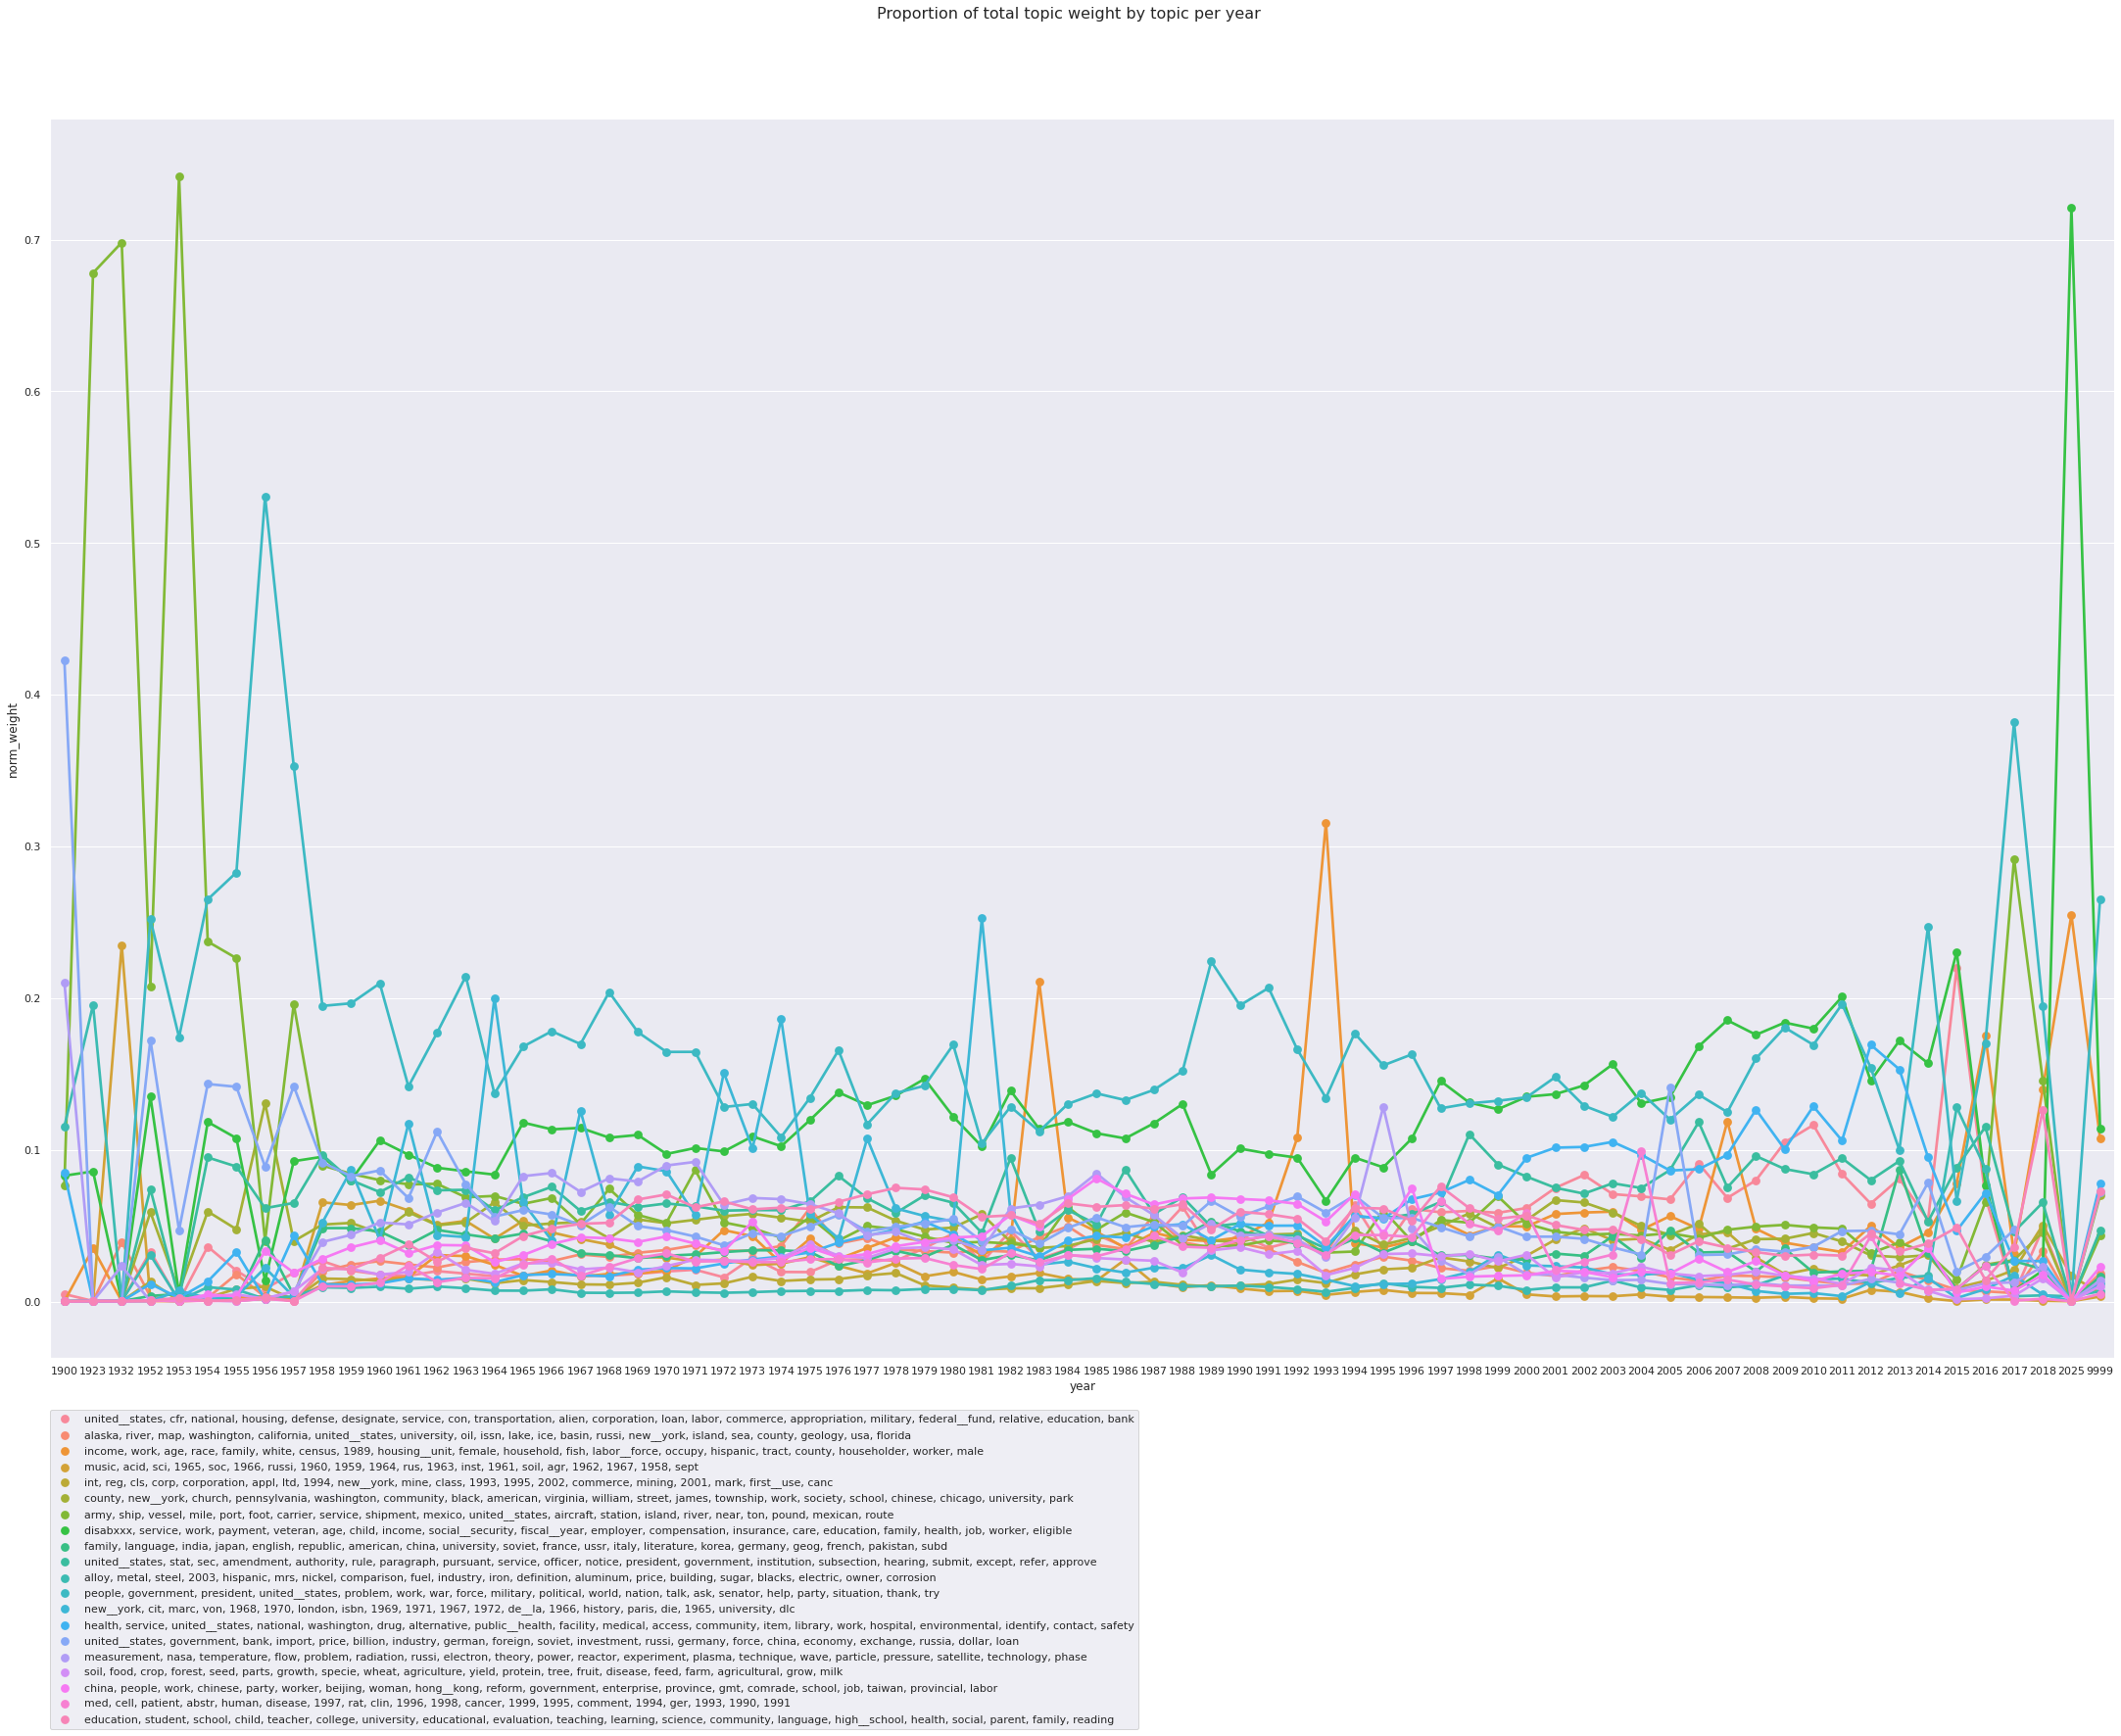

In [32]:
create_pointplot(df, "norm_weight", hue="topic_terms", title="Proportion of total topic weight by topic per year", offset=-0.3, height=20)

In [27]:
create_pointplot(df, 'norm_weight', col='topic_terms', wrap=4, height=20,
                 title="Central Range of Normalized Topic Weights Split by Topic", plt_legend=False)